# [DEMO] SDXL - Sketch to Realistic Image

SDXL can generate realistic product image from sketch
In this notebook, we compare 3 SDXL variants to find the most suitable checkpoint for our goal: 
- `SDXL Default`
- `RealVis V2.0` (realistic finetuned)
- `Juggernaut XL` (realistic finetuned)

Using `TencentARC/t2i-adapter-sketch-sdxl-1.0` as controlnet.

Then, we do experiment with `SDXL Refine` to see how this model can improve generated image, it's reported that `SDXL Refine` can help to generate more realistic, textured image

## Preparation
1. Download 3 SDXL-checkpoints by run this command: `bash scripts/download_sd_model.sh`
2. Install the requirements: `pip install -U transformers datasets accelerate diffusers`

In [1]:
from diffusers.utils import load_image
import torch
from utils import *

SDXL_MODELS = {
    "juggernaut_xl": "models/sdxl/juggernautxl.safetensors",
    "realvis_xl": "models/sdxl/realvisxl.safetensors",
    "base": "models/sdxl/sdxl.safetensors",
}
SDXL_CONTROLNET_REPO_NAME = "TencentARC/t2i-adapter-sketch-sdxl-1.0"


/opt/conda/lib/python3.10/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


In [2]:
# DEFINE SAMPLE DATA FOR TESTING

sketch_data = {
    "shoes_1": {
        "url": "https://user-images.githubusercontent.com/4512269/281333019-1bfe511e-a5ed-4b31-8380-5b7406688d19.png",
        "user_prompt": "a fashion shoes",
    },
    "shoes_2": {
        "url": "https://user-images.githubusercontent.com/4512269/281333030-59effd86-054a-4dad-905e-b46226e909c5.jpg",
        "user_prompt": "running Nike shoe",
    },
    "shoes_3": {
        "url": "https://user-images.githubusercontent.com/4512269/281333032-49f620a5-e0f3-483f-a4c6-2db4dc562c19.png",
        "user_prompt": "a casual shoe",
    },
    "backpack_1": {
        "url": "https://user-images.githubusercontent.com/4512269/281333036-93ce5cc1-66aa-4fa6-bea6-4c99fab2d3be.jpeg",
        "user_prompt": "a casual, waterproof backpack",
    },
    "dress_1": {
        "url": "https://user-images.githubusercontent.com/4512269/281333044-e2994d8d-d7fb-4544-a3a9-1ef14d990544.jpeg",
        "user_prompt": "a colorful dress"
    },
    "dress_2": {
        "url": "https://user-images.githubusercontent.com/4512269/281333046-cf0fc5fd-a6d2-4d1e-a2c6-dec9b10a2af6.jpg",
        "user_prompt": "a white wedding dress",
    },
    "dress_3": {
        "url": "https://www.newarc.ai/_next/image?url=%2F_next%2Fstatic%2Fmedia%2Fwedding-dress-0.d00432a2.png&w=1200&q=75",
        "user_prompt": "a yellow dress"
    },
    "hoodie_1": {
        "url": "https://user-images.githubusercontent.com/4512269/281333050-6e9c9d04-1758-461b-9881-eba77b7bcacb.jpg",
        "user_prompt": "a hoodie for Noel",
    }
}

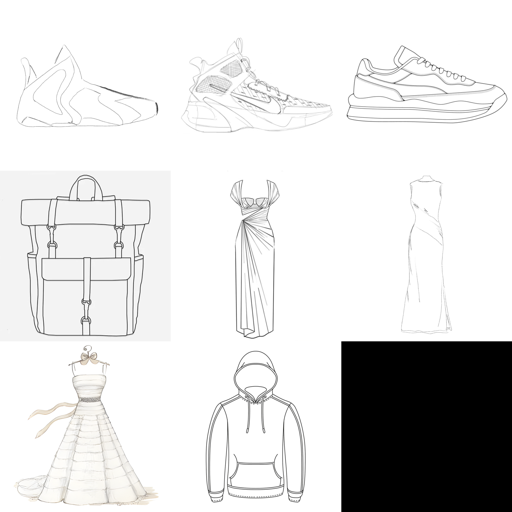

In [3]:
# PLOT INPUT IMAGES

raw_images = [load_image(item['url']) for item in sketch_data.values()]
sketch_images = [resize_square(image, 512) for image in raw_images]
image_grid(sketch_images, 3).resize((512,512))

/opt/conda/lib/python3.10/site-packages/controlnet_aux/pidi/model.py:334: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449201336/work/torch/csrc/tensor/python_tensor.cpp:83.)
  buffer = torch.cuda.FloatTensor(shape[0], shape[1], 5 * 5).fill_(0)


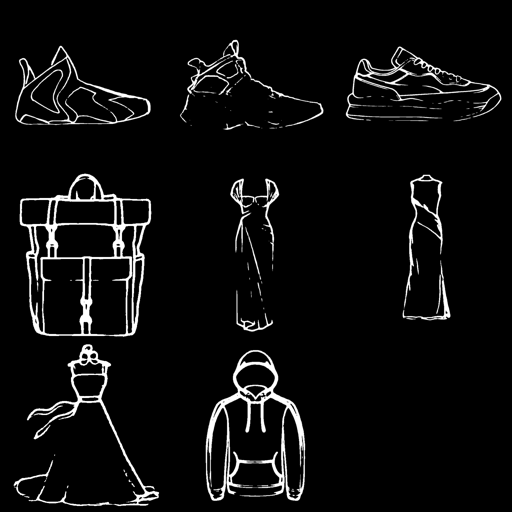

In [4]:
# PLOT THE CONTROLNET INPUT IMAGES

canny_images = [preprocess_sketch(image, 512, 512) for image in raw_images]
image_grid(canny_images, 3).resize((512, 512))

## INFER TESTING DATA
- We do inference with 3 SDXLs on testing samples.
- Then we run `SDXL Refiner` with these generated images.
- All generated images are saved then uploaded to Huggingface to analyze more convenience.
- The ultimate goal of these cells is generate images for comparison: between SDXLs; w/w.o `SDXL Refiner`

Uploaded Data: https://huggingface.co/datasets/toilaluan/controlnet_fashion_sdxl

### SDXLs inference

In [5]:
def infer_sample_data(
        pipe, 
        data: dict, 
        prefix_filename: str, 
        preprocess_func, 
        preprocess_image_size: int = 1024, 
        output_image_size: int = 1024, 
        num_inference_steps: int = 30,
        seed: int = 0,
        guidance_scale: float = 7.5, 
        adapter_conditioning_scale=0.9,
    ):
    """
    Processes a batch of images using a generative model pipeline.

    Args:
    pipe: Diffusers Pipeline
    data: A dictionary with items containing a URL and user prompt for each image.
    prefix_filename: String prefix for the output file names.
    preprocess_func: Function to preprocess the images for controlnet.
    preprocess_image_size: Size for image resizing during preprocessing (default 1024).
    output_image_size: Size of the output images (default 1024).
    num_inference_steps: Number of steps for model inference (default 30).
    seed: Seed for random number generation (default 0).
    guidance_scale: Scale of guidance for the model (recommended 7.5).
    adapter_conditioning_scale: Scale for adapter conditioning in the generative process (recommended 0.9).

    Returns:
    - Saved Image
    - A list of metadata for all processed items.
    """

    metadatas = []
    generator = torch.manual_seed(seed)
    for item_name, item_data in tqdm(data.items(), total=len(data)):
        file_name = f"{prefix_filename}-{item_name}.png"
        image = load_image(item_data['url']).convert("RGB")
        processed_image = preprocess_func(image, preprocess_image_size, output_image_size)
        prompt, negative_prompt = prompting(item_data['user_prompt'])
        generated_images = pipe(
            prompt, 
            negative_prompt = negative_prompt, 
            image=processed_image, 
            generator=generator, 
            num_inference_steps=num_inference_steps, 
            height=output_image_size, 
            width=output_image_size, 
            guidance_scale=guidance_scale, 
            num_images_per_prompt=4,
            adapter_conditioning_scale = adapter_conditioning_scale,
        ).images
        generated_grid = image_grid(generated_images, 4)
        generated_grid.save(os.path.join("outputs", file_name))
        metadata = {
            "prompt": prompt,
            "negative_prompt": negative_prompt,
            "preprocess_image_size": preprocess_image_size,
            "output_image_size": output_image_size,
            "num_inference_steps": num_inference_steps,
            "seed": seed,
            "generate_size": output_image_size,
            "file_name": file_name
        }
        metadata.update(item_data)
        metadatas.append(metadata)
    return metadatas

In [6]:
import shutil
import os

shutil.rmtree("outputs", ignore_errors=True)
os.makedirs("outputs", exist_ok=True)

In [7]:
from diffusers import StableDiffusionXLAdapterPipeline, T2IAdapter, EulerAncestralDiscreteScheduler, AutoencoderKL
import torch
import json

adapter = T2IAdapter.from_pretrained(
     SDXL_CONTROLNET_REPO_NAME, torch_dtype=torch.float16
).to("cuda")
total_metadatas = []
for sdxl_name, sdxl_file in SDXL_MODELS.items():
    print("Infer", sdxl_name)
    pipe = StableDiffusionXLAdapterPipeline.from_single_file(sdxl_file, adapter=adapter, torch_dtype=torch.float16, use_safetensors=True)
    pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
    pipe.to("cuda")
    metadatas = infer_sample_data(pipe, sketch_data, sdxl_name, preprocess_sketch)
    total_metadatas.extend(metadatas)

Infer juggernaut_xl


/opt/conda/lib/python3.10/site-packages/diffusers/pipelines/pipeline_utils.py:749: FutureWarning: `torch_dtype` is deprecated and will be removed in version 0.25.0. 
  deprecate("torch_dtype", "0.25.0", "")
  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:18<02:06, 18.01s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:34<01:43, 17.19s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:51<01:24, 16.96s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

 50%|█████     | 4/8 [01:07<01:07, 16.84s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [01:24<00:50, 16.82s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

 75%|███████▌  | 6/8 [01:41<00:33, 16.79s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

 88%|████████▊ | 7/8 [01:58<00:16, 16.72s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 8/8 [02:14<00:00, 16.85s/it]


Infer realvis_xl


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:17<02:00, 17.22s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:34<01:42, 17.10s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:51<01:25, 17.06s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

 50%|█████     | 4/8 [01:08<01:07, 16.95s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [01:25<00:51, 17.02s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

 75%|███████▌  | 6/8 [01:42<00:34, 17.09s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

 88%|████████▊ | 7/8 [01:59<00:17, 17.06s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 8/8 [02:16<00:00, 17.08s/it]


Infer base


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:17<02:00, 17.19s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:33<01:41, 16.84s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:50<01:24, 16.96s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

 50%|█████     | 4/8 [01:07<01:07, 16.81s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [01:24<00:50, 16.84s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

 75%|███████▌  | 6/8 [01:41<00:34, 17.01s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

 88%|████████▊ | 7/8 [01:58<00:16, 16.94s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 8/8 [02:15<00:00, 16.91s/it]


In [8]:
import torch
del pipe
with torch.no_grad():
    torch.cuda.empty_cache()

### Refiner infererence

In [ ]:
from diffusers import StableDiffusionXLImg2ImgPipeline
from PIL import Image
import torch

pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
pipe.enable_model_cpu_offload()
pipe.to("cuda")

In [10]:
import json
from PIL import Image
import os
from copy import deepcopy


add_refine_metadatas = deepcopy(total_metadatas)

for metadata in tqdm(total_metadatas):
    generator = torch.manual_seed(0)
    init_image = Image.open(os.path.join("outputs", metadata['file_name'])).convert("RGB")
    prompt = metadata['prompt']
    negative_prompt = metadata['negative_prompt']
    image = pipe(prompt, negative_prompt=negative_prompt, image=init_image, num_inference_steps=30, generator=generator).images[0]
    file_name = f"refined-{metadata['file_name']}"
    image.save(os.path.join("outputs", file_name))
    metadata.update({
        "file_name": file_name
    })
    add_refine_metadatas.append(metadata)


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:12<04:45, 12.41s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

  8%|▊         | 2/24 [00:24<04:26, 12.10s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 12%|█▎        | 3/24 [00:35<04:10, 11.91s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 17%|█▋        | 4/24 [00:47<03:58, 11.93s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 21%|██        | 5/24 [00:59<03:46, 11.90s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 25%|██▌       | 6/24 [01:11<03:33, 11.85s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 29%|██▉       | 7/24 [01:23<03:21, 11.83s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 8/24 [01:35<03:09, 11.83s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 38%|███▊      | 9/24 [01:47<02:59, 11.94s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 42%|████▏     | 10/24 [01:59<02:48, 12.04s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 46%|████▌     | 11/24 [02:11<02:36, 12.03s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 50%|█████     | 12/24 [02:23<02:24, 12.01s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 54%|█████▍    | 13/24 [02:35<02:13, 12.11s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 58%|█████▊    | 14/24 [02:48<02:01, 12.15s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 62%|██████▎   | 15/24 [03:00<01:49, 12.17s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 67%|██████▋   | 16/24 [03:12<01:37, 12.23s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 71%|███████   | 17/24 [03:24<01:25, 12.17s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 75%|███████▌  | 18/24 [03:36<01:12, 12.04s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 79%|███████▉  | 19/24 [03:48<01:00, 12.11s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 83%|████████▎ | 20/24 [04:00<00:48, 12.07s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 88%|████████▊ | 21/24 [04:13<00:36, 12.16s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 92%|█████████▏| 22/24 [04:25<00:24, 12.23s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 96%|█████████▌| 23/24 [04:37<00:12, 12.14s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 24/24 [04:49<00:00, 12.07s/it]


### Upload data to Huggingface

In [ ]:
import pandas as pd

df = pd.DataFrame(add_refine_metadatas)
df.to_csv("outputs/metadata.csv", index=False)

In [11]:
df.to_csv("outputs/metadata.csv", index=False)

In [12]:
from datasets import load_dataset

In [13]:
ds = load_dataset("imagefolder", data_dir='outputs')
ds

Resolving data files:   0%|          | 0/49 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'prompt', 'negative_prompt', 'preprocess_image_size', 'output_image_size', 'num_inference_steps', 'seed', 'generate_size', 'url', 'user_prompt'],
        num_rows: 48
    })
})

In [14]:
ds.push_to_hub(repo_id="toilaluan/controlnet_fashion_sdxl", token="")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/48 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/643 [00:00<?, ?B/s]

## Comparision